In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
import matplotlib.pyplot as plt

d:\ProgramFiles\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [74]:
Feature_UoB_Set01_LOBs = pd.read_csv("C:\\Users\\zoec0\\Desktop\\DSMP\\LSTM预测股票价格\\Featured_Clean_UoB_Set01_2025-01-02LOBs.txt").dropna()
Feature_UoB_Set01_LOBs =Feature_UoB_Set01_LOBs[1:].reset_index().drop("index", axis=1)
Feature_UoB_Set01_LOBs

,transaction_quantity_sum,transaction_quantity_sum.1,transaction_quantity_sum.2,transaction_quantity_sum.3,transaction_quantity_sum.4,transaction_quantity_sum.5,transaction_count_sum,transaction_count_sum.1,transaction_count_sum.2,transaction_count_sum.3,...,bid_ask_spread_std.4,bid_ask_spread_std.5,start_time,end_time,size_tau2,size_tau2.1,size_tau2.2,size_tau2.3,size_tau2.4,size_tau2.5
0,107.0,203.0,289.0,398.0,488.0,604.0,53,101,144,193,...,20.469905,18.774648,10.0,610.0,0.058321,0.125141,0.080837,0.058926,0.041350,0.025983
1,109.0,206.0,293.0,403.0,507.0,603.0,54,100,144,193,...,20.405054,18.760151,20.0,620.0,0.058621,0.123977,0.081240,0.058926,0.041350,0.025820
2,101.0,203.0,291.0,403.0,512.0,600.0,49,96,142,192,...,20.447711,18.743252,30.0,630.0,0.058926,0.130149,0.082916,0.059339,0.041458,0.025766
3,102.0,198.0,283.0,392.0,506.0,599.0,51,96,140,190,...,20.520457,18.731088,40.0,640.0,0.058824,0.127572,0.082916,0.059761,0.041675,0.025766
4,100.0,207.0,293.0,391.0,507.0,596.0,48,96,141,191,...,20.550471,18.749914,50.0,650.0,0.058824,0.131498,0.082916,0.059549,0.041566,0.025874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2994,134.0,228.0,313.0,420.0,520.0,647.0,55,99,144,196,...,22.346349,22.994135,29950.0,30550.0,0.058521,0.122845,0.081650,0.058926,0.041033,0.025928
2995,136.0,232.0,321.0,419.0,536.0,646.0,56,100,147,195,...,23.025690,22.614524,29960.0,30560.0,0.058321,0.121743,0.081240,0.058321,0.041138,0.025713
2996,128.0,224.0,316.0,415.0,530.0,638.0,54,98,146,192,...,22.801159,21.864980,29970.0,30570.0,0.058621,0.123977,0.082065,0.058521,0.041458,0.025660
2997,121.0,211.0,300.0,408.0,516.0,623.0,50,92,139,189,...,23.341765,21.575156,29980.0,30580.0,0.059235,0.128841,0.084699,0.059976,0.041786,0.025983


In [17]:
clean_uob_set01_tapes = pd.read_csv("C:\\Users\\zoec0\\Desktop\\DSMP\\Clean\\Tape\\Clean_UoB_Set01_2025-01-02tapes.csv")


In [18]:
# 补点函数
def resample_and_adjust_using_original_times(df, target_count):
    # Creating a new column 'Time_bin' to convert 'Time' values into 10-second bins
    df['Time_bin'] = (df['Time'] // 10 * 10).astype(int)
    
    all_time_bins = range(df['Time_bin'].min(), df['Time_bin'].max() + 10, 10)
    grouped = df.groupby('Time_bin')

    new_records = []
    last_known_price = None 
    
    # Iterating through all possible time bins
    for time_bin in all_time_bins:
        # If the current time bin exists within the grouped data
        if time_bin in grouped.groups:
            group = grouped.get_group(time_bin)
            times = group['Time'].values
            prices = group['Weighted_Price'].values
            # If the prices array is not empty, update the last known price
            if len(prices) > 0:
                last_known_price = prices[-1]
        else:
            group = None 
            
        # If the current time bin is empty or has only one price data point
        if group is None or len(prices) == 0:
            prices = np.full(target_count, last_known_price)
            times = np.linspace(time_bin, time_bin + 9, num=target_count)
        elif len(prices) == 1:
            times = np.linspace(time_bin, time_bin + 9, num=target_count)
            prices = np.full(target_count, last_known_price)
        else:
            # If there are fewer data points than the target count, additional points will be added
            while len(prices) < target_count:
                time_diffs = np.diff(times)
                idx_to_fill = np.argmax(time_diffs)
                new_time = (times[idx_to_fill] + times[idx_to_fill + 1]) / 2
                new_price = (prices[idx_to_fill] + prices[idx_to_fill + 1]) / 2
                times = np.insert(times, idx_to_fill + 1, new_time)
                prices = np.insert(prices, idx_to_fill + 1, new_price)
            # If there are multiple data points within the time bin, proceed with normal processing
            while len(prices) > target_count:
                time_diffs = np.diff(times)
                idx_to_merge = np.argmin(time_diffs)
                new_time = (times[idx_to_merge] + times[idx_to_merge + 1]) / 2
                new_price = (prices[idx_to_merge] + prices[idx_to_merge + 1]) / 2
                times = np.delete(times, [idx_to_merge, idx_to_merge + 1])
                times = np.insert(times, idx_to_merge, new_time)
                prices = np.delete(prices, [idx_to_merge, idx_to_merge + 1])
                prices = np.insert(prices, idx_to_merge, new_price)
         # Add the processed data to the results list          
        new_records.extend(zip(times, prices))

    new_df = pd.DataFrame(new_records, columns=['Time', 'Weighted_Price'])
    new_df.sort_values('Time', inplace=True)
    return new_df



In [19]:
processed_df = resample_and_adjust_using_original_times(clean_uob_set01_tapes, 6)

In [63]:
def create_dataset(data, time_step, step=6):
    X, y = [], []
    for i in range(0, len(data)-time_step, step):
        X.append(data[i:(i+time_step), 0])
        y.append(data[(i+time_step):(i+time_step+6), 0])  
    return np.array(X), np.array(y)



In [65]:
price = processed_df['Weighted_Price'].values.reshape(-1, 1)
#scaled_data = scaler.fit_transform(price)

time_step = 360
_,tags=create_dataset(price, time_step, step=6)



In [84]:
features

scaler.fit_transform(features)

array([[0.53153153, 0.57738095, 0.44502618, ..., 0.37296861, 0.38922042,
        0.41059201],
       [0.54954955, 0.5952381 , 0.46596859, ..., 0.37296861, 0.38922042,
        0.37549233],
       [0.47747748, 0.57738095, 0.45549738, ..., 0.40583262, 0.40293004,
        0.36393832],
       ...,
       [0.72072072, 0.70238095, 0.58638743, ..., 0.34078222, 0.40293004,
        0.34104465],
       [0.65765766, 0.625     , 0.5026178 , ..., 0.45645225, 0.44470975,
        0.41059201],
       [0.69369369, 0.60119048, 0.51832461, ..., 0.43939836, 0.45885807,
        0.41059201]])

In [85]:
# 归一化处理
scaler = MinMaxScaler()

#scaler_target = MinMaxScaler()

####### 改为特征数据表特征值
features = Feature_UoB_Set01_LOBs
features = scaler.fit_transform(features)
####### tape
targets = tags
targets = scaler.fit_transform(targets)
    
# 划分数据集
split_idx = int(0.8 * len(features))
X_train, X_test = features[:split_idx], features[split_idx:]
y_train, y_test = targets[:split_idx], targets[split_idx:]

# 模型构建
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(248,1)),
    Dropout(0.2),
    LSTM(30, return_sequences=False),
    Dense(6)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)
#循环所有数据集的时候改成具体数据集
#model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=)

# 模型评估
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Mean Squared Error on Test Set:", mse)
print("Root Mean Squared Error on Test Set:", rmse)



Epoch 1/50


d:\ProgramFiles\Anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - loss: 0.1869 - val_loss: 0.0225
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - loss: 0.0342 - val_loss: 0.0322
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - loss: 0.0261 - val_loss: 0.0395
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - loss: 0.0274 - val_loss: 0.0319
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - loss: 0.0255 - val_loss: 0.0261
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - loss: 0.0241 - val_loss: 0.0250
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - loss: 0.0247 - val_loss: 0.0226
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - loss: 0.0237 - val_loss: 0.0189
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - loss: 0.0231 - val_loss: 0.0167
Epoch 10/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - loss: 0.0221 - val_loss: 0.0208
Epoch 11/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - loss: 0.0207 - val_loss: 0.0146
Epoch 12/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - l

KeyboardInterrupt: 

In [88]:
# 新数据点预测
new_predictions = model.predict(X_test)
new_predictions_rescaled = scaler.inverse_transform(new_predictions)
print("Predicted Values:", new_predictions_rescaled)



19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Predicted Values: [[287.12552 287.16138 288.66483 287.97003 288.10757 287.53842]
 [287.90533 287.66498 289.3857  288.97037 288.53693 288.54694]
 [287.80972 287.6119  289.24765 288.80972 288.46072 288.4196 ]
 ...
 [289.5484  287.93298 291.0117  289.17383 289.4676  290.86963]
 [287.00143 284.58505 288.83798 287.38678 286.35858 288.86078]
 [286.67703 284.34857 288.64066 287.13278 286.19272 288.49722]]


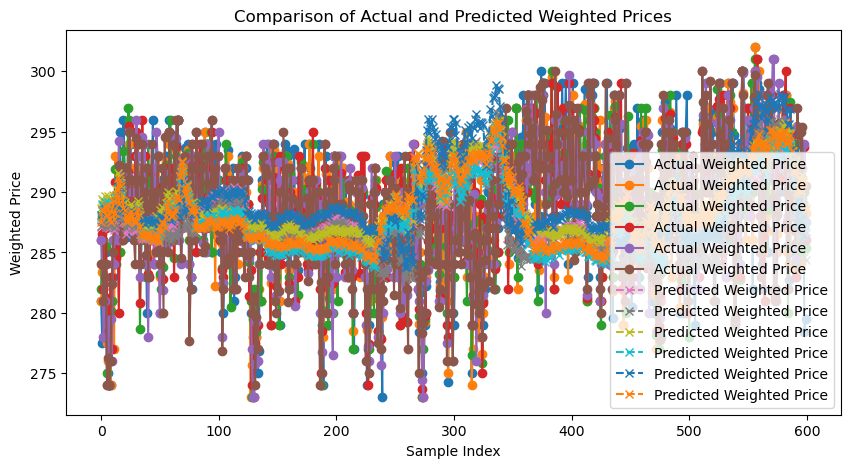

In [91]:
# 可视化实际值与预测值
plt.figure(figsize=(10, 5))
plt.plot(scaler.inverse_transform(y_test), label='Actual Weighted Price', marker='o')
plt.plot(scaler.inverse_transform(new_predictions), label='Predicted Weighted Price', linestyle='--', marker='x')
plt.title('Comparison of Actual and Predicted Weighted Prices')
plt.xlabel('Sample Index')
plt.ylabel('Weighted Price')
plt.legend()
plt.show()



In [93]:
mse = mean_squared_error(y_test, new_predictions)
rmse = np.sqrt(mse)
print("Mean Squared Error on Test Set:", mse)
print("Root Mean Squared Error on Test Set:", rmse)

Mean Squared Error on Test Set: 0.009946409652080107
Root Mean Squared Error on Test Set: 0.09973168830457102
